# Import

In [112]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xgboost import XGBClassifier

# Statics

In [113]:
df_path = r"fraud-detection-data.xlsx"

label_column_name = "label"

rf_model_filename = 'fraud_detection_rf_model.joblib'
xgb_model_filename = 'fraud_detection_xgb_model.joblib'

In [114]:
data = pd.read_excel(df_path)

# Enrich feature

## Date

In [115]:
# Date
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])

# Extract features from 'Transaction Date'
data['DayOfWeek'] = data['Transaction Date'].dt.day_name()
data['HourOfDay'] = data['Transaction Date'].dt.hour

# Sort the dataframe by 'Transaction Date'
data = data.sort_values(by='Transaction Date')

In [116]:
data.head(3)

,Transaction Date,Card/Account,Holder Name,Payer IP,IP Country,Remark,Statement Reference,label,DayOfWeek,HourOfDay
7,2023-01-06 18:20:40,522440******4756,Chittrawan Rangsimahariwong,49.237.4.16,TH,#10443,MONEYSP*KARTONEXP,n,Friday,18
1,2023-01-07 22:30:33,543215******6187,Audrey Warner,103.144.245.176,**,NaN,MONEYSP*KARTONEXP,y,Saturday,22
0,2023-01-08 22:10:27,527517******6525,Alexis Hernandez,213.255.247.56,GB,NaN,MONEYSP*KARTONEXP,n,Sunday,22


## Number of uses

In [117]:
# Calculate the time difference between consecutive transactions for each 'Holder Name'
data['TimeDiff'] = data.groupby('Holder Name')['Transaction Date'].diff()

# Identify transactions within a 5-minute window
within_5mins = data['TimeDiff'] <= pd.Timedelta(minutes=5)

# Calculate the cumulative sum of transactions within 5 minutes for each 'Holder Name'
data['CumulativeTransactions'] = within_5mins.groupby(data['Holder Name']).cumsum()

# Reset index for plotting
data.reset_index(drop=True, inplace=True)

In [118]:
data.head(5)

,Transaction Date,Card/Account,Holder Name,Payer IP,IP Country,Remark,Statement Reference,label,DayOfWeek,HourOfDay,TimeDiff,CumulativeTransactions
0,2023-01-06 18:20:40,522440******4756,Chittrawan Rangsimahariwong,49.237.4.16,TH,#10443,MONEYSP*KARTONEXP,n,Friday,18,NaT,0
1,2023-01-07 22:30:33,543215******6187,Audrey Warner,103.144.245.176,**,NaN,MONEYSP*KARTONEXP,y,Saturday,22,NaT,0
2,2023-01-08 22:10:27,527517******6525,Alexis Hernandez,213.255.247.56,GB,NaN,MONEYSP*KARTONEXP,n,Sunday,22,NaT,0
3,2023-01-08 23:39:32,437551******2016,Binti Daud,58.136.190.229,TH,NaN,MONEYSP*KARTONEXP,y,Sunday,23,NaT,0
4,2023-01-08 23:39:32,485498******2922,Binti Daud,58.136.190.229,TH,NaN,MONEYSP*KARTONEXP,y,Sunday,23,0 days,1


# EDA

## Origin

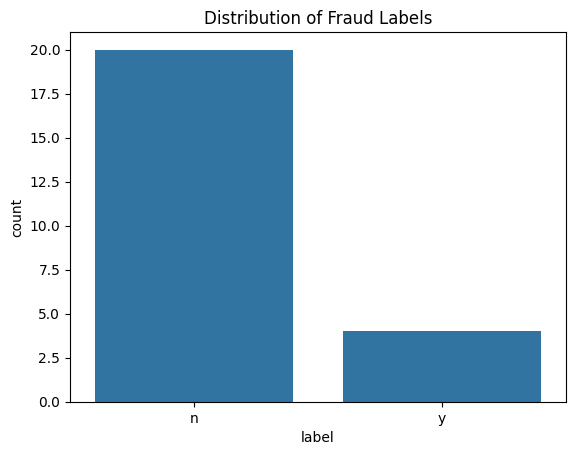

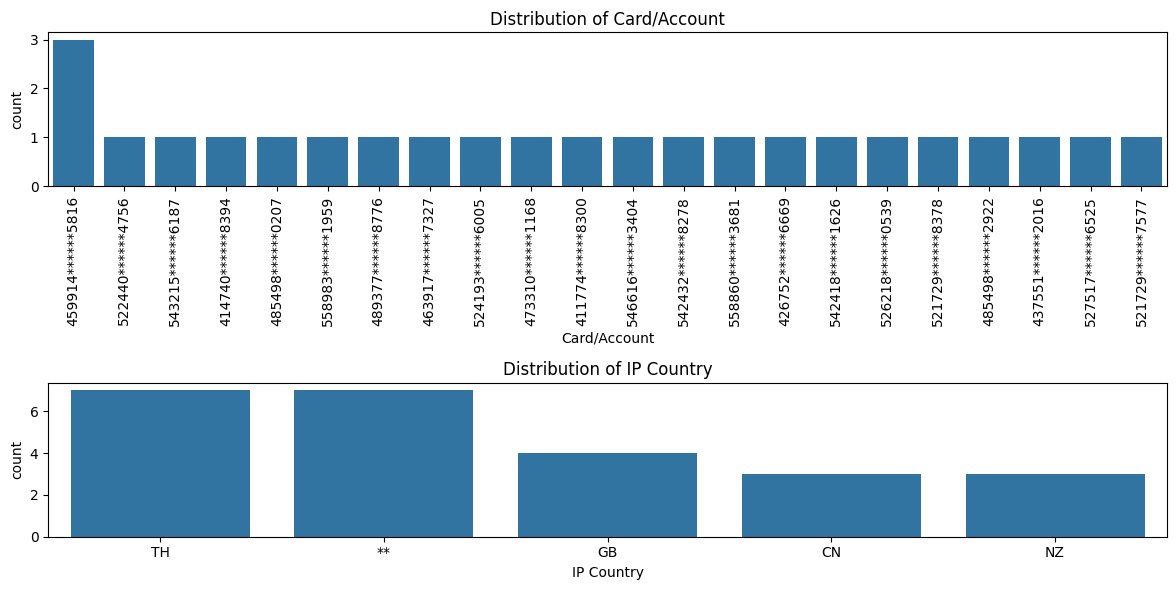

In [119]:
# Explore the distribution of the target variable 'label'
sns.countplot(x='label', data=data)
plt.title('Distribution of Fraud Labels')
plt.show()

# Explore the distribution of 'Card/Account' and 'IP Country'
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
sns.countplot(x='Card/Account', data=data, order=data['Card/Account'].value_counts().index)
plt.title('Distribution of Card/Account')
plt.xticks(rotation=90)

plt.subplot(2, 1, 2)
sns.countplot(x='IP Country', data=data, order=data['IP Country'].value_counts().index)
plt.title('Distribution of IP Country')

plt.tight_layout()
plt.show()

# Enriched

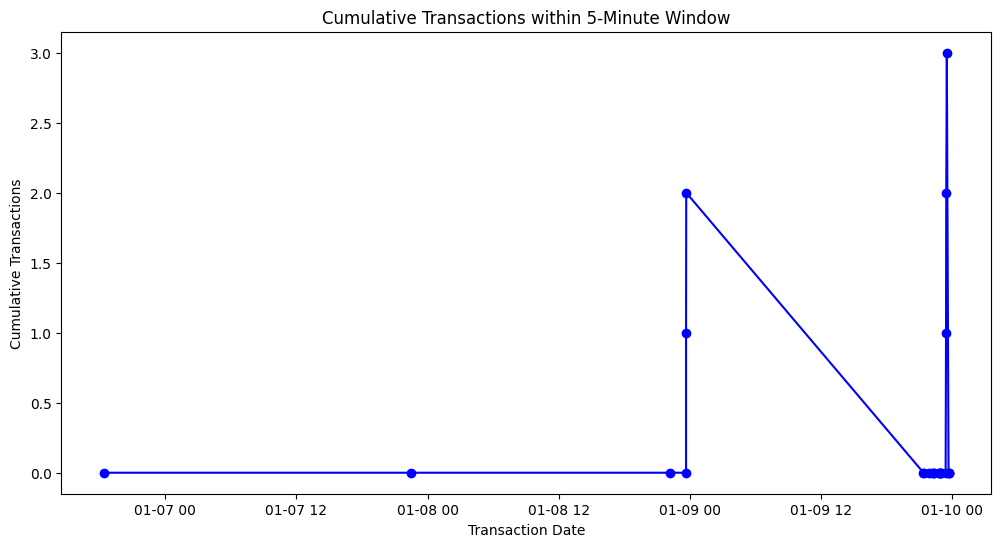

In [120]:
# Plotting number of transaction vs time
plt.figure(figsize=(12, 6))
plt.plot(data['Transaction Date'], data['CumulativeTransactions'], marker='o', linestyle='-', color='b')
plt.title('Cumulative Transactions within 5-Minute Window')
plt.xlabel('Transaction Date')
plt.ylabel('Cumulative Transactions')
plt.show()

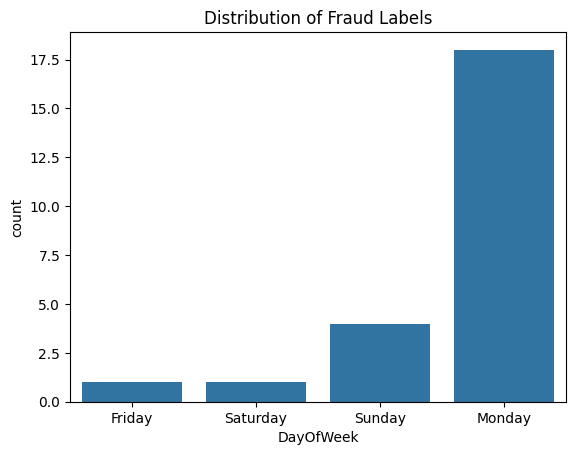

In [121]:
sns.countplot(x='DayOfWeek', data=data)
plt.title('Distribution of Fraud Labels')
plt.show()

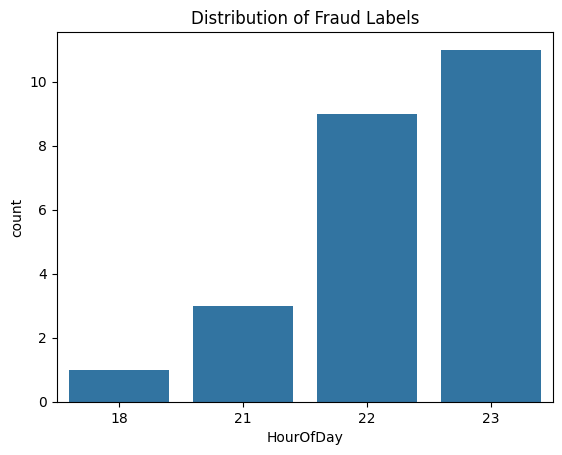

In [122]:
sns.countplot(x='HourOfDay', data=data)
plt.title('Distribution of Fraud Labels')
plt.show()

# Feature engineering

In [123]:
data['label'] = data['label'].map({'n': 0, 'y': 1})

In [124]:
# Convert 'TimeDiff' to numeric (seconds)
data['TimeDiff_seconds'] = data['TimeDiff'].dt.total_seconds()

# Define features (X) and target variable (y)
X = data[['HourOfDay', 'CumulativeTransactions', 'TimeDiff_seconds']]
y = data['label']

# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['HourOfDay'])

In [125]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
X_train.head(3)

,CumulativeTransactions,TimeDiff_seconds,HourOfDay_18,HourOfDay_21,HourOfDay_22,HourOfDay_23
9,0,NaN,False,False,True,False
13,0,NaN,False,False,True,False
1,0,NaN,False,False,True,False


In [127]:
y_train.head()

9     0
13    0
1     1
21    0
5     1
Name: label, dtype: int64

# Modeling

## Random forest

In [128]:
# Build the RandomForest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [129]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

/Users/dev/fastwork/fraud-detection/env_jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [130]:
# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 1.0
Confusion Matrix:
[[5]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



## XGBoost

In [131]:
xgb_model = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [132]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

/Users/dev/fastwork/fraud-detection/env_jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [133]:
# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 1.0
Confusion Matrix:
[[5]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



# Post modeling

In [134]:
# Save the trained model to a file
joblib.dump(rf_model, rf_model_filename)
joblib.dump(xgb_model, xgb_model_filename)

['fraud_detection_xgb_model.joblib']